In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

In [2]:
fatal = pd.read_csv("fatal-police-shootings-data.csv")
fatal_rm = fatal.groupby(["race", "signs_of_mental_illness"]).agg({"name": "count"})
fatal_rm.reset_index(level=1, inplace=True)
fatal_mental=fatal.groupby(['signs_of_mental_illness']).agg({'name':'count'})
fatal_mental

,name
signs_of_mental_illness,
False,4200
True,1216


In [3]:
def percent(x):
        if x["signs_of_mental_illness"] == True:
            rate = x["name"] * 100 / 1216
            return round(rate, 2)
        elif x["signs_of_mental_illness"] == False:
            rate = x["name"] * 100 / 4200
            return round(rate, 2)

fatal_rm["fatal_percent_of_ill_by_race[%]"] = fatal_rm.apply(lambda x: percent(x), axis=1)
fatal_rm.rename({"name": "count"}, axis=1, inplace=True)
fatal_rm

,signs_of_mental_illness,count,fatal_percent_of_ill_by_race[%]
race,,,
A,False,69,1.64
A,True,24,1.97
B,False,1114,26.52
B,True,184,15.13
H,False,745,17.74
H,True,157,12.91
N,False,64,1.52
N,True,14,1.15
O,False,37,0.88


In [14]:
fatal_rm_mental = fatal_rm[fatal_rm.signs_of_mental_illness == True]
#fatal_rm_mental.sort_values(by="fatal_percent_of_ill_by_race[%]", ascending=False)
fatal_rm_mental.sort_values(by="fatal_percent_of_ill_by_race[%]", ascending=False).to_csv("tmp/fatal_mental.csv")
race = fatal_rm_mental["fatal_percent_of_ill_by_race[%]"].idxmax()
percent = fatal_rm_mental["fatal_percent_of_ill_by_race[%]"].max()
f"Największy procent ofiar z objawami choroby psychicznej jest wśród rasy {race} i wynosi {percent}%"

'Największy procent ofiar z objawami choroby psychicznej jest wśród rasy W i wynosi 58.63%'

In [5]:
fatal["date"] = pd.to_datetime(fatal["date"])
fatal["date"].dt.day_name()
fatal_day = fatal.join(fatal["date"].dt.day_name(), rsuffix="_day")
fatal_weekday = fatal_day.groupby(["date_day"]).agg({"name": "count"})
fatal_weekday.reset_index(inplace=True)
fatal_weekday.rename(columns={"name": "count"}, inplace=True)

<Axes: xlabel='date_day'>

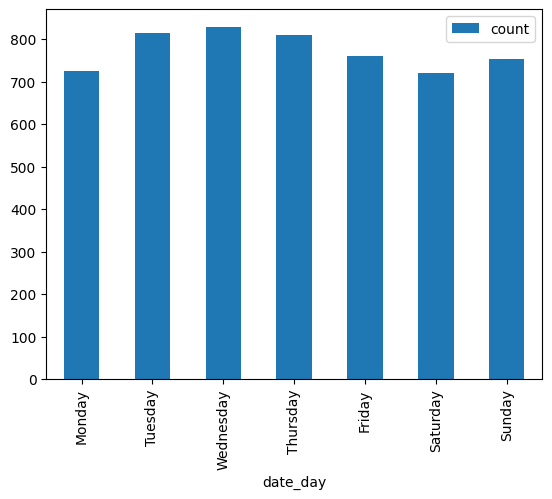

In [6]:
cats = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
]
cat_type = CategoricalDtype(categories=cats, ordered=True)
fatal_weekday["date_day"] = fatal_weekday["date_day"].astype(cat_type)
fatal_weekday = fatal_weekday.groupby(["date_day"]).sum().reindex(cats)
fatal_weekday.reset_index(inplace=True)
fatal_weekday.to_csv("fatal_weekday.csv")
fatal_rm.to_csv("fatal_rm.csv")
fatal_weekday.plot(x="date_day", y="count", kind="bar")

In [7]:
state_pop = pd.read_html("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population", header=0)
state_pop[0].to_csv("tmp/pop_tmp.csv")
pop = state_pop[0].sort_values(by="State")
pop.columns = range(0, 11)
pop.drop([0, 1, 3, 5, 6, 7, 8, 9, 10], axis=1, inplace=True)
pop.shape

(60, 2)

In [8]:
state_name = pd.read_html("https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations#Table", header=0)
state_name = state_name[0]
state_name.reset_index(inplace=True)
state_name.drop(state_name.index[0:11], inplace=True)
state_name.columns = range(1, 12)
state_name.drop([1, 3, 4, 5, 6, 8, 9, 10, 11], axis=1, inplace=True)
state_name.to_csv("tmp/state_name.csv")
state_name.shape

(77, 2)

In [9]:
state_name.columns = [2, 3]
state_name.head(5)

,2,3
11,Alabama,AL
12,Alaska,AK
13,Arizona,AZ
14,Arkansas,AR
15,California,CA


In [10]:
pop_by_state = pd.merge(pop, state_name, how="left")
pop_by_state.columns = ["state_full", "pop", "state"]
pop_by_state.sample(5)

,state_full,pop,state
55,Utah,2763885,UT
31,Nebraska,1826341,NE
26,Michigan,9883640,MI
59,West Virginia,1852994,WV
1,Alaska,710231,AK


In [11]:
fatal_by_state = fatal.groupby(["state"]).agg({"name": "count"})
fatal_by_state.reset_index(inplace=True)

fatal_by_state_pop = pd.merge(fatal_by_state, pop_by_state, how="left")
fatal_by_state_pop.head()

,state,name,state_full,pop
0,AK,39,Alaska,710231
1,AL,104,Alabama,4779736
2,AR,83,Arkansas,2915918
3,AZ,254,Arizona,6392017
4,CA,799,California,37253956


In [12]:
def fatal_per_pop(row):
        rate = 1000 * row["name"] / row["pop"]
        return round(rate, 4)
fatal_by_state_pop["fatal per 1000"] = fatal_by_state_pop.apply(lambda row: fatal_per_pop(row), axis=1)
fatal_by_state_pop.rename({"name": "count"}, axis=1, inplace=True)
fatal_by_state_pop.to_csv("fatality_by_state.csv")